## Imports

In [1]:
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import time
import subprocess
import shutil
import json

## Data Preprocessing

In [2]:
# Kaggle Loaded Dataset Path (readonly)
root_input = Path("/kaggle/input/imagenet-reduced-100/reduced_imagenet/")

# Working Dataset Path to modify the default
root_working = Path("/kaggle/working/reduced_imagenet")
root_working.mkdir(exist_ok=True)

if root_working.exists():
    print("The working directory was created successfully.")
else:
    print("There seems to be an issue.")

The working directory was created successfully.


In [3]:
# Loading all the labels
labels_path = Path(root_input / "labels.json")

# Reading the Raw JSON Labels
labels = json.loads(labels_path.read_text())
print(json.dumps(labels, indent=4))

{
    "n01968897": "chambered nautilus",
    "n01770081": "harvestman",
    "n01818515": "macaw",
    "n02011460": "bittern",
    "n01496331": "electric ray",
    "n01847000": "drake",
    "n01687978": "agama",
    "n01740131": "night snake",
    "n01537544": "indigo bunting",
    "n01491361": "tiger shark",
    "n02007558": "flamingo",
    "n01735189": "garter snake",
    "n01630670": "common newt",
    "n01440764": "tench",
    "n01819313": "sulphur-crested cockatoo",
    "n02002556": "white stork",
    "n01667778": "terrapin",
    "n01755581": "diamondback",
    "n01924916": "flatworm",
    "n01751748": "sea snake",
    "n01984695": "spiny lobster",
    "n01729977": "green snake",
    "n01614925": "bald eagle",
    "n01608432": "kite",
    "n01443537": "goldfish",
    "n01770393": "scorpion",
    "n01855672": "goose",
    "n01560419": "bulbul",
    "n01592084": "chickadee",
    "n01914609": "sea anemone",
    "n01582220": "magpie",
    "n01667114": "mud turtle",
    "n01985128": "cr

In [4]:
# No of Classes to be trained
n_classes = 40

# Selecting the First N_Classes from the Labels
reduced_labels = dict(list(labels.items())[:n_classes])
reduced_labels

{'n01968897': 'chambered nautilus',
 'n01770081': 'harvestman',
 'n01818515': 'macaw',
 'n02011460': 'bittern',
 'n01496331': 'electric ray',
 'n01847000': 'drake',
 'n01687978': 'agama',
 'n01740131': 'night snake',
 'n01537544': 'indigo bunting',
 'n01491361': 'tiger shark',
 'n02007558': 'flamingo',
 'n01735189': 'garter snake',
 'n01630670': 'common newt',
 'n01440764': 'tench',
 'n01819313': 'sulphur-crested cockatoo',
 'n02002556': 'white stork',
 'n01667778': 'terrapin',
 'n01755581': 'diamondback',
 'n01924916': 'flatworm',
 'n01751748': 'sea snake',
 'n01984695': 'spiny lobster',
 'n01729977': 'green snake',
 'n01614925': 'bald eagle',
 'n01608432': 'kite',
 'n01443537': 'goldfish',
 'n01770393': 'scorpion',
 'n01855672': 'goose',
 'n01560419': 'bulbul',
 'n01592084': 'chickadee',
 'n01914609': 'sea anemone',
 'n01582220': 'magpie',
 'n01667114': 'mud turtle',
 'n01985128': 'crayfish',
 'n01820546': 'lorikeet',
 'n01773797': 'garden spider',
 'n02006656': 'spoonbill',
 'n01986

In [5]:
print("Copy Process Started")

for parent_node in root_input.iterdir():
     # Avoiding the Label File
    if not parent_node.is_dir():
        continue

    # Retrieving the Split Name
    split_name = parent_node.stem

    # Executing the Copy based on the Split Name
    if split_name == "train" :
        dest_path = root_working / "train"
    elif split_name == "valid":
        dest_path = root_working / "valid"
    else:
        print(f"Skipping unrecognised branch: {parent_node}")
        continue

    # Creating the directory
    dest_path.mkdir(exist_ok=True)

    # Iterating through the classes on sub-nodes
    for sub_node in parent_node.iterdir():

        # If Class ID in Reduced => Backtrack the name and copy
        if sub_node.stem in reduced_labels.values():
            class_name = sub_node.stem
            completed_path = dest_path / class_name
            shutil.copytree(sub_node, completed_path, dirs_exist_ok=True)

print("Copy Process Completed")

Copy Process Started
Copy Process Completed


## The Data Handler Object

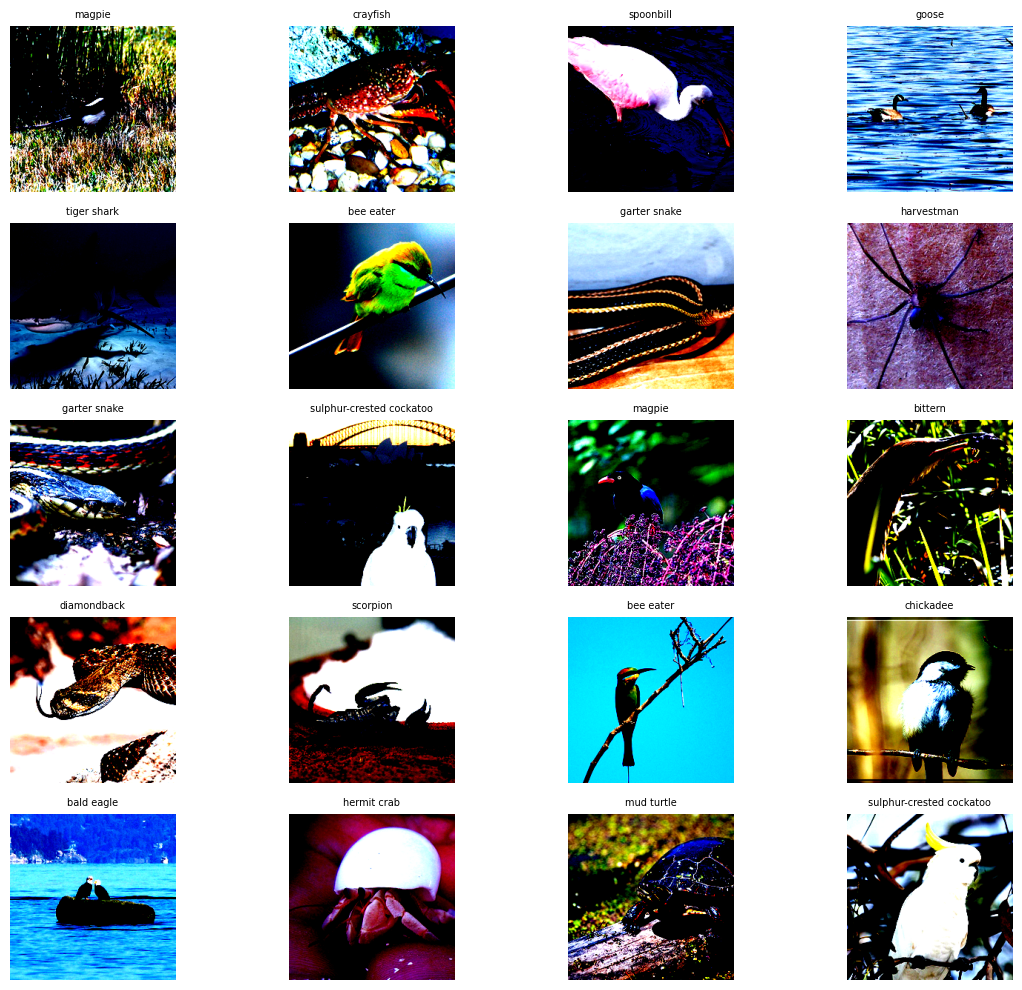

In [6]:
# Dataset Working Path
dataset_path = root_working


class DataHandler:
    """This class is responsible for loading the datasets."""
    def __init__(self, root_dir: Path) -> None:
        self.root_dir = root_dir
        self.norm_means = [0.485, 0.456, 0.406]
        self.norm_stds = [0.229, 0.224, 0.225]

        self.apply_transforms = v2.Compose([
            v2.Resize(size=256, interpolation=v2.InterpolationMode.BICUBIC),  # Maintaining the Aspect Ratio
            v2.CenterCrop(size=(224, 224)),  # Crop the Image to the Subject
            v2.ToImage(),  # Converts PIL Image to Tensor
            v2.ToDtype(torch.float32, scale=True),  # Converting the Dtype for Normalisation
            v2.Normalize(mean=self.norm_means, std=self.norm_stds),  # Applies Normalisation
        ])

    def load_set(self, set_name: str) -> DatasetFolder:
        """Loads the set by the specified set_name."""

        if set_name == "train":
            dataset_path = self.root_dir / "train"
        elif set_name == "valid":
            dataset_path = self.root_dir / "valid"
        else:
            raise UnboundLocalError("Invalid set name provided.")

        dataset = ImageFolder(root=dataset_path, transform=self.apply_transforms)
        self.class_names = dataset.classes
        return dataset

    def move_samples_from_train(
        self, train_set: DatasetFolder, 
        move_percent: float = 0.12
    ) -> tuple[Subset, Subset]:
        """Moves a fixed number of samples from train to valid for better split."""

        targets = np.array(train_set.targets)
        indices = range(len(train_set))
        
        # Stratified Sampling of the Train Set
        train_indices, valid_indices = train_test_split(
            indices, test_size=move_percent, stratify=targets
        )
        
        # Subsets
        train_set_pre_prep = Subset(train_set, train_indices)
        valid_set_pre_prep = Subset(train_set, valid_indices)

        return train_set_pre_prep, valid_set_pre_prep
    
    def prepare_dataset(self, dataset: DatasetFolder, batch_size: int=64, shuffle: bool=True) -> DataLoader:
        """Returns the prepared and loaded dataset."""

        return DataLoader(
            dataset=dataset, 
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=4
        )
    
    def view_images(self, loaded_set: DataLoader) -> None:
        """Helper function just to view the images."""
        images, targets = next(iter(loaded_set))

        plt.figure(figsize=(12, 10))
        for i in range(20):
            img = images[i].squeeze()
            label = targets[i]

            plt.subplot(5, 4, i + 1)
            plt.title(f"{self.class_names[label]}", fontdict={"size": 7})
            plt.imshow(img.permute(1, 2, 0))
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()


# Testing
data_handle = DataHandler(root_dir=dataset_path)
train_loaded = data_handle.load_set("train")
train_prep = data_handle.prepare_dataset(dataset=train_loaded)
class_names = data_handle.class_names
data_handle.view_images(loaded_set=train_prep)

In [7]:
# Class Names as in the dataset
print("Total No of Classes: ", n_classes)
print("\nClass Names:\n", class_names)

Total No of Classes:  40

Class Names:
 ['agama', 'bald eagle', 'bee eater', 'bittern', 'bulbul', 'chambered nautilus', 'chickadee', 'common newt', 'crayfish', 'diamondback', 'drake', 'electric ray', 'flamingo', 'flatworm', 'garden spider', 'garter snake', 'goldfish', 'goose', 'great white shark', 'green mamba', 'green snake', 'harvestman', 'hermit crab', 'indigo bunting', 'kite', 'lorikeet', 'macaw', 'magpie', 'mud turtle', 'night snake', 'scorpion', 'sea anemone', 'sea snake', 'spiny lobster', 'spoonbill', 'sulphur-crested cockatoo', 'tench', 'terrapin', 'tiger shark', 'white stork']


## MultiHead Self-Attention Block

In [8]:
class MultiHeadSelfAttention(torch.nn.Module):
    """This class implements the MultiHead Self-Attention Mechanism that is central to Transformers."""

    def __init__(self, embed_dims: int = 768, n_heads: int = 12, in_features: int = 768, dropout_rate: float = 0.2) -> None:
        
        # Loading all the properties from the Super Class
        super().__init__()

        # Instance Variables of the MHSA
        self.embed_dims = embed_dims
        self.n_heads = n_heads

        # Head Size
        self.head_size = self.embed_dims // self.n_heads

        # Attention Matrices
        self.queries_full = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)
        self.keys_full = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)
        self.values_full = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)

        # Context Sharing Layer
        self.context_share = torch.nn.Linear(in_features=in_features, out_features=embed_dims, bias=True)

        # Dropout Layer
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Applies the forward propagation for the entire MultiHead Self-Attention Block.
        
        For implementation efficiency it calculates the Linear Transformations for the Q, K, V on the full input.
        It then permutes the tensors into individual heads to calculate the attention scores and provide the output.
        
        args:
        - X: torch.Tensor -> Expected Batch_Size, N_Patch + 1 [CLS Token], Embedding Dim.
        
        returns:
        - torch.Tensor -> Batch_Size, N_Patch + 1 [CLS Token], Embedding Dim."""

        # Input Dimensions
        B, T, C = X.shape

        # Scaling Constant for attention calculation
        scaling_const = self.head_size ** -0.5

        # Calculating all the Linear Projections
        queries: torch.Tensor = self.queries_full(X)  # 197, 768 @ 768, 768 => (Batch_Size, 197, 768)
        keys: torch.Tensor = self.keys_full(X)        # 197, 768 @ 768, 768 => (Batch_Size, 197, 768)
        values: torch.Tensor = self.values_full(X)    # 197, 768 @ 768, 768 => (Batch_Size, 197, 768)

        # Reshaping the tensor to Self Attention Head Sizes for Calculation
        queries = queries.reshape((B, T, self.n_heads, self.head_size))  # Batch_Size, 197, 12, 64
        keys = keys.reshape((B, T, self.n_heads, self.head_size))        # Batch_Size, 197, 12, 64
        values = values.reshape((B, T, self.n_heads, self.head_size))    # Batch_Size, 197, 12, 64

        # Permuting the Tensors for MultiHead Attention Calculation
        queries_mhsa = torch.permute(input=queries, dims=[0, 2, 1, 3])   # Batch_Size, 12, 197, 64
        keys_mhsa = torch.permute(input=keys, dims=[0, 2, 1, 3])         # Batch_Size, 12, 197, 64
        values_mhsa = torch.permute(input=values, dims=[0, 2, 1, 3])     # Batch_Size, 12, 197, 64

        # MultiHead Attention Pattern Calculation for each Attention Head
        attention_pattern_mhsa = queries_mhsa @ keys_mhsa.transpose(-2, -1) * scaling_const  # 197, 64 @ 64, 197 => Batch_Size, 12, 197, 197
        attention_pattern_mhsa = torch.nn.functional.softmax(attention_pattern_mhsa, dim=-1)

        # Weighted Score
        attended_embeddings_mhsa = attention_pattern_mhsa @ values_mhsa  # 197, 197 @ 197, 64 => Batch_Size, 12, 197, 64

        # Resized Attension Scores
        attended_embeddings = attended_embeddings_mhsa.permute(dims=[0, 2, 1, 3])   # Batch_Size, 197, 12, 64
        attended_embeddings = attended_embeddings.flatten(start_dim=2, end_dim=-1)  # Batch_Size, 197, 768

        # Context Sharing
        rich_embeddings = self.context_share(attended_embeddings)  # 197, 768 @ 768, 768 => 197, 786

        # Dropout Reg for better Generalization of the Attention Scores
        regularized_rich_embeddings = self.dropout(rich_embeddings)

        return regularized_rich_embeddings


# Testing
mhsa = MultiHeadSelfAttention()
print(mhsa)

MultiHeadSelfAttention(
  (queries_full): Linear(in_features=768, out_features=768, bias=False)
  (keys_full): Linear(in_features=768, out_features=768, bias=False)
  (values_full): Linear(in_features=768, out_features=768, bias=False)
  (context_share): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Feedforward Block

In [9]:
class FeedForward(torch.nn.Module):
    """This class implements a position-wise feed-forward network applied to each token in the sequence."""

    def __init__(self, embed_dims: int = 768) -> None:

        # Inheriting all the properties of the Super Class
        super().__init__()

        # Sequential Feedfoward Block
        self.feed_forward_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=embed_dims, out_features=embed_dims * 4, bias=True),  # Up-Projection from Attention Embeddings
            torch.nn.GELU(),
            torch.nn.Linear(in_features=embed_dims * 4, out_features=embed_dims, bias=True),  # Down-Projection for Residual Connection
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of the simple feedfoward block.
        
        args:
        - X: torch.Tensor -> Batch_Size, N_Patch, Embedding Dims
        
        returns:
        - torch.Tensor -> Batch_Size, N_Patch, Embedding Dims"""

        return self.feed_forward_block(X)


# Testing
ffwd = FeedForward()
print(ffwd)

FeedForward(
  (feed_forward_block): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)


## Vision Encoder Block

In [10]:
class VisionEncoder(torch.nn.Module):
    """This class implements the complete Vision Encoder block for the Vision Transformer."""

    def __init__(self, embed_dims: int = 768, n_heads: int = 12, in_features: int = 768, dropout_rate: float = 0.2):

        # Loading all the properties from the Super Class
        super().__init__()

        # MultiHead Self-Attention Block
        self.mhsa_block = MultiHeadSelfAttention(
            embed_dims=embed_dims,
            n_heads=n_heads,
            in_features=in_features,
            dropout_rate=dropout_rate
        )

        # Feedfoward Block
        self.ff_block = FeedForward(embed_dims=embed_dims)

        # Normalization Layers
        self.ln1 = torch.nn.LayerNorm(embed_dims)
        self.ln2 = torch.nn.LayerNorm(embed_dims)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the complete forward propagation of a single Vision Encoder block."""

        # MultiHead Self-Attention Embeddings Calculation
        attention_out = self.mhsa_block(self.ln1(X))
        residual_attention_scores = attention_out + X

        # Position-Wise Feedfoward Calculation
        ff_logits = self.ff_block(self.ln2(residual_attention_scores))
        final_residual_scores = ff_logits + residual_attention_scores

        return final_residual_scores


# Testing
vision_encoder = VisionEncoder()
print(vision_encoder)

VisionEncoder(
  (mhsa_block): MultiHeadSelfAttention(
    (queries_full): Linear(in_features=768, out_features=768, bias=False)
    (keys_full): Linear(in_features=768, out_features=768, bias=False)
    (values_full): Linear(in_features=768, out_features=768, bias=False)
    (context_share): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (ff_block): FeedForward(
    (feed_forward_block): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


## The Vision Transformer

In [11]:
class VisionTransformer(torch.nn.Module):
    """This class implements the complete Vision Transformer from scratch."""

    def __init__(
            self, n_classes: int, n_layers: int = 12, image_size: int = 224, 
            patch_size: int = 16, embed_dims: int = 768, n_heads: int = 12, 
            in_features: int = 768, dropout_rate: float = 0.2
        ) -> None:

        # Loading all the properties from the Super Class
        super().__init__()

        # Vision Transformer Properties
        self.n_patches = image_size // patch_size

        # Initial Convolution Layer
        self.patch_conv = torch.nn.Conv2d(
            in_channels=3,
            out_channels=embed_dims,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Positional Embeddings
        self.positional_embeddings = torch.nn.Embedding(
            num_embeddings=(self.n_patches ** 2) + 1,
            embedding_dim=embed_dims
        )

        # Vision Transformer Encoder Blocks
        self.deep_encoder_blocks = torch.nn.Sequential(
            *[
                VisionEncoder(
                    embed_dims=embed_dims,
                    n_heads=n_heads,
                    in_features=in_features,
                    dropout_rate=dropout_rate
                )
                for _ in range(n_layers)
            ]
        )

        # Final Layer Norm before MLP Head
        self.final_ln = torch.nn.LayerNorm(embed_dims)

        # MLP Head
        self.mlp_head = torch.nn.Linear(
            in_features=embed_dims,
            out_features=n_classes,
            bias=True
        )

        # Learnable Class Token a small random value
        self.cls_token = torch.nn.Parameter(
            data=torch.randn(1, 1, embed_dims) * 0.02
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of the complete Vision Transformer."""

        # Initial Conv
        image_conv: torch.Tensor = self.patch_conv(X)  # Batch_Size, 768, 14, 14

        # Patch Embeddings
        image_tensors: torch.Tensor = image_conv.flatten(start_dim=-2, end_dim=-1)  # Batch_Size, 768, 196
        image_patches: torch.Tensor = image_tensors.permute(dims=[0, 2, 1])         # Batch_Size, 196, 768

        # Prepending the Learnable CLS Token
        image_patches = torch.cat(
            [
                self.cls_token.expand(X.shape[0], -1, -1),
                image_patches
            ],
            dim=1
        )

        # Position Embedding
        pos_scores = self.positional_embeddings(
            torch.arange(
                start=0, 
                end=(self.n_patches ** 2) + 1,
                device=torch.accelerator.current_accelerator()
            )
        )

        # Image Patch Embeddings
        image_patch_embeddings = image_patches + pos_scores

        # Deep Vision Encoder blocks
        deep_logits = self.deep_encoder_blocks(image_patch_embeddings)

        # MLP Head
        final_logits = self.mlp_head(self.final_ln(deep_logits[:, 0]))

        return final_logits


# Testing
first_vit = VisionTransformer(n_classes=n_classes)
print("Model Architecture:\n")
print(first_vit, end="\n\n")

num_params = sum(module.numel() for module in first_vit.parameters() if module.requires_grad)
print(f"Total no of learnable params: {num_params}")

Model Architecture:

VisionTransformer(
  (patch_conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embeddings): Embedding(197, 768)
  (deep_encoder_blocks): Sequential(
    (0): VisionEncoder(
      (mhsa_block): MultiHeadSelfAttention(
        (queries_full): Linear(in_features=768, out_features=768, bias=False)
        (keys_full): Linear(in_features=768, out_features=768, bias=False)
        (values_full): Linear(in_features=768, out_features=768, bias=False)
        (context_share): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff_block): FeedForward(
        (feed_forward_block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e

## Training Loop Handler

In [12]:
CHECKPOINT_PATH = "./models"


class TrainingLoop:
    """This class handles the training loop for the models."""
    def __init__(self, learning_rate: float, model: torch.nn.Module):
        self.model = model
        self.optim = torch.optim.AdamW(
            params=self.model.parameters(),
            lr=learning_rate
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = torch.nn.CrossEntropyLoss()

        # Learning Rate Scheduler
        self.lr_schedule = ReduceLROnPlateau(
            optimizer=self.optim, mode="min", patience=2, min_lr=1e-7
        )

        # Creating the Checkpoint Storage Directory
        self.model_dir = Path(CHECKPOINT_PATH)
        if not self.model_dir.exists():
            self.model_dir.mkdir()
    
    def train_model(
            self, epochs: int,
            train_set: DataLoader, valid_set: DataLoader
        ) -> tuple[list[float], list[float]]:
        """Trains the model for the given number of epochs."""

        # Cache Losses
        train_losses = []
        valid_losses = []

        # Mean Training Variables
        mean_loss_train = 0
        mean_loss_valid = 0

        # Training Checkpoint
        best_valid_loss = torch.inf
        patience = 5
        patience_counter = 0

        # Training Loop
        print("The training process has started")
        for i in range(epochs):

            # Average Epoch Time tracking
            start = time.time()

            # ==== Training Step ====

            # Completing a single epoch
            for X, y in train_set:

                # Moving the batches to GPU
                X, y = X.to(self.device), y.to(self.device)
            
                # Training Step
                logits = self.model(X)

                # Loss Calculation
                train_loss = self.loss_fn(input=logits, target=y)
                train_loss = train_loss.sum()
                mean_loss_train += train_loss.item()

                # Backpropagation
                self.optim.zero_grad()
                train_loss.backward()
                self.optim.step()

            # Completion of Epoch
            end = time.time()

            # ==== Validation Step ====

            # Turning on the Eval mode on the model for the BN-Layers
            self.model.eval()
            with torch.no_grad():
                for X, y in valid_set:

                    # Moving the batches to GPU
                    X, y = X.to(self.device), y.to(self.device)

                    # Validation Calculation
                    logits = self.model(X)

                    # Loss Calculation
                    valid_loss = self.loss_fn(input=logits, target=y)
                    valid_loss = valid_loss.sum()
                    mean_loss_valid += valid_loss.item()
            
            # Switching the model back to training mode
            self.model.train()

            # ==== End of Epoch Metrics & Model Checkpointing ====
            mean_loss_train /= len(train_set)
            mean_loss_valid /= len(valid_set)
            time_epoch = end - start

            # Update the LR-Schedule
            self.lr_schedule.step(mean_loss_valid)

            # Updating the Caches
            train_losses.append(mean_loss_train)
            valid_losses.append(mean_loss_valid)

            print(f"Epoch {i + 1}: Train Loss -> {mean_loss_train:.4f} | Valid Loss -> {mean_loss_valid:.4f} | Time Epoch -> {time_epoch:.4f}")

            # Updating the best validation loss so far
            if mean_loss_valid < best_valid_loss:
                best_valid_loss = mean_loss_valid

                # Saving the Model by weights
                torch.save(obj=self.model.state_dict(), f=self.model_dir / "vit_base_16.pth")
                print("New best model was saved")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"No improvement: {patience_counter} / {patience}")
                if patience_counter >= patience:
                    print("Early Stopping")
                    break

            # ==== Reset the Training Loop Metrics ====
            mean_loss_train, mean_loss_valid = 0, 0
        
        return train_losses, valid_losses


# Testing
optim = TrainingLoop(learning_rate=1e-4, model=first_vit)
print(optim)

## The Main Function

In [13]:
# Learning Curve Asset Path
ASSET_PATH = Path("/kaggle/working/assets")

# Accelerator Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Accelerator Available: {DEVICE}")
print(f"Units: {torch.cuda.device_count()}")

Accelerator Available: cuda
Units: 2


Initial Sample Sizes:
Train Set:
Counter({0: 1300, 1: 1300, 2: 1300, 3: 1300, 4: 1300, 5: 1300, 6: 1300, 7: 1300, 8: 1300, 9: 1300, 10: 1300, 11: 1300, 12: 1300, 13: 1300, 14: 1300, 15: 1300, 16: 1300, 17: 1300, 18: 1300, 19: 1300, 20: 1300, 21: 1300, 22: 1300, 23: 1300, 24: 1300, 25: 1300, 26: 1300, 27: 1300, 28: 1300, 29: 1300, 30: 1300, 31: 1300, 32: 1300, 33: 1300, 34: 1300, 35: 1300, 36: 1300, 37: 1300, 38: 1300, 39: 1300})

Valid Set:
Counter({0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 50, 13: 50, 14: 50, 15: 50, 16: 50, 17: 50, 18: 50, 19: 50, 20: 50, 21: 50, 22: 50, 23: 50, 24: 50, 25: 50, 26: 50, 27: 50, 28: 50, 29: 50, 30: 50, 31: 50, 32: 50, 33: 50, 34: 50, 35: 50, 36: 50, 37: 50, 38: 50, 39: 50})

 ------- 

Moved Sample Sizes:
Train Set:
Counter({4: 1105, 34: 1105, 30: 1105, 17: 1105, 26: 1105, 10: 1105, 23: 1105, 35: 1105, 1: 1105, 24: 1105, 8: 1105, 18: 1105, 36: 1105, 0: 1105, 33: 1105, 29: 1105, 3: 1105, 2: 1105, 28: 1105,

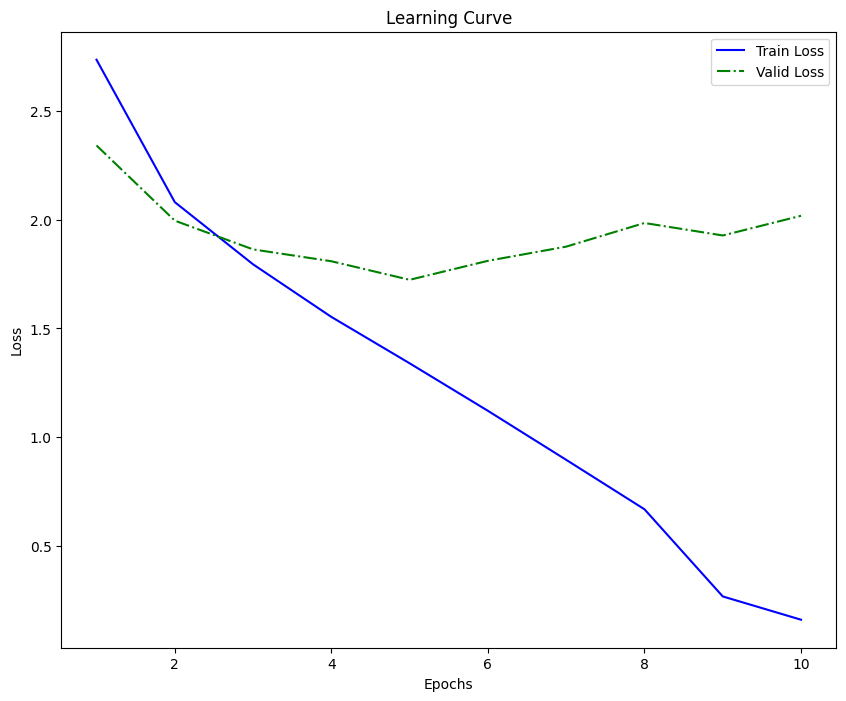

In [14]:
def main():
    # Initialising the DataHandler
    data_handle = DataHandler(root_dir=root_working)

    # Loading the Dataset
    loaded_train_set = data_handle.load_set("train")
    loaded_valid_set = data_handle.load_set("valid")
    
    # Initial sample sizes
    print("Initial Sample Sizes:")
    train_count = Counter(loaded_train_set.targets)
    valid_count = Counter(loaded_valid_set.targets)
    print(f"Train Set:\n{train_count}")
    print(f"\nValid Set:\n{valid_count}")
    print("\n ------- \n")

    # Moving Samples
    train_set_pre_prep, valid_set_pre_prep = data_handle.move_samples_from_train(loaded_train_set, move_percent=0.15)
    
    print("Moved Sample Sizes:")
    train_targets = [loaded_train_set.targets[i] for i in train_set_pre_prep.indices]
    valid_targets = [loaded_train_set.targets[i] for i in valid_set_pre_prep.indices]
    train_count = Counter(train_targets)
    valid_count = Counter(valid_targets)
    print(f"Train Set:\n{train_count}")
    print(f"\nValid Set:\n{valid_count}")
    print("\n ------- \n")

    # Preparing the sets
    train_set = data_handle.prepare_dataset(train_set_pre_prep)
    valid_set_combined = ConcatDataset([loaded_valid_set, valid_set_pre_prep])
    valid_set = data_handle.prepare_dataset(valid_set_combined)

    # Loading the model
    model_base = VisionTransformer(n_classes=n_classes).to(DEVICE)
    vit_base_16 = torch.nn.DataParallel(model_base)

    # Loading the Training Loop Handler
    optimizer = TrainingLoop(learning_rate=1e-4, model=vit_base_16)

    # Training and Validating the model
    train_losses, valid_losses = optimizer.train_model(30, train_set=train_set, valid_set=valid_set)

    # Plotting the losses
    plt.figure(figsize=(10, 8))
    plt.title("Learning Curve")
    plt.plot(range(1, len(train_losses) + 1), train_losses, c="b", ls="-", label="Train Loss")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, c="g", ls="-.", label="Valid Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Storing the Learning Curve
    if not ASSET_PATH.exists():
        ASSET_PATH.mkdir()
    plt.savefig(ASSET_PATH / "learning_curve.png")

    # Rendering the plot
    plt.show()


# ==== Driver Code ====
if __name__ == "__main__":
    main()

In [15]:
# Clearing Train and Valid in Working
if root_working.exists():
    shutil.rmtree(root_working)

print("Cleared Working Path!!")

Cleared Working Path!!
